In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
tf.enable_eager_execution()
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import PIL.Image as Image

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
splits = tfds.Split.ALL.subsplit(weighted=(80,20))
(splits, info) = tfds.load("tf_flowers", with_info=True, as_supervised=True, split=splits)
(training_set, validation_set) = splits
num_examples = info.splits['train'].num_examples
print('Total Number of Images:', num_examples)

Total Number of Images: 3670


In [4]:
# We have to iterate over the training set to count its size
num_training_examples = 0
for i in iter(training_set):
    num_training_examples+=1
    
# The same goes for the validation set
num_validation_examples = 0
for i, img in iter(validation_set):
    num_validation_examples+=1
    
# The number of classes can just be grabbed from the info object
num_classes = info.features['label'].num_classes

print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {}'.format(num_validation_examples))
print('Total Number of Classes: {}'.format(num_classes))

Total Number of Training Images: 2950
Total Number of Validation Images: 720
Total Number of Classes: 5


In [5]:
for i, example in enumerate(training_set.take(5)):
    print('Image {} shape: {} label: {}'.format(i+1,example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 3
Image 2 shape: (229, 320, 3) label: 4
Image 3 shape: (325, 500, 3) label: 4
Image 4 shape: (240, 209, 3) label: 3
Image 5 shape: (334, 500, 3) label: 4


In [0]:
IMAGE_RES = 224
BATCH_SIZE = 32

In [0]:
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.
    return image, label

train_batches = training_set.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [0]:
URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [0]:
feature_extractor.trainable = False

In [10]:
L = [
    feature_extractor,
    tf.keras.layers.Dense(units=num_classes, activation='softmax')
]
model = tf.keras.Sequential(L)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [35]:
EPOCHS = 12
history = model.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)

Epoch 1/12
93/93 [==============================] - 35s 376ms/step - loss: 0.1792 - acc: 0.9512 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/12
93/93 [==============================] - 35s 378ms/step - loss: 0.1624 - acc: 0.9566 - val_loss: 0.3051 - val_acc: 0.9028
Epoch 3/12
93/93 [==============================] - 35s 375ms/step - loss: 0.1481 - acc: 0.9627 - val_loss: 0.2988 - val_acc: 0.9042
Epoch 4/12
93/93 [==============================] - 35s 378ms/step - loss: 0.1358 - acc: 0.9668 - val_loss: 0.2934 - val_acc: 0.9042
Epoch 5/12
93/93 [==============================] - 35s 375ms/step - loss: 0.1250 - acc: 0.9708 - val_loss: 0.2889 - val_acc: 0.9028
Epoch 6/12
93/93 [==============================] - 35s 375ms/step - loss: 0.1155 - acc: 0.9739 - val_loss: 0.2854 - val_acc: 0.9042
Epoch 7/12
93/93 [==============================] - 35s 375ms/step - loss: 0.1070 - acc: 0.9773 - val_loss: 0.2828 - val_acc: 0.9056
Epoch 8/12
93/93 [==============================] - 35s 377ms

Text(0.5, 1.0, 'Training and Validation Loss')

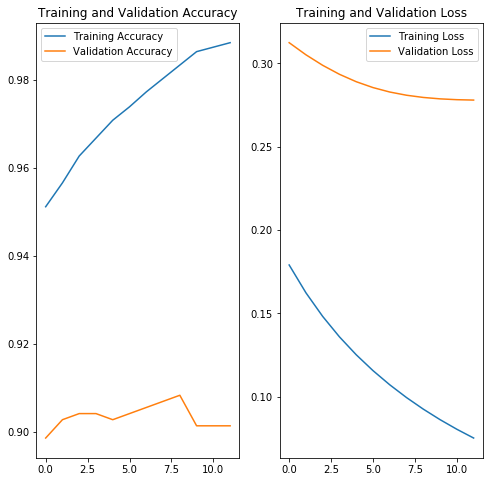

In [37]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [14]:
# Important: convert to NumPy array to enable fancy indexing
class_names = np.array(info.features['label'].names)
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [33]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()
predicted_batch = model.predict(image_batch)
#predicted_batch = predicted_batch.numpy()

predicted_ids = np.argmax(predicted_batch, axis=1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

['dandelion' 'daisy' 'dandelion' 'roses' 'roses' 'tulips' 'roses' 'roses'
 'roses' 'sunflowers' 'roses' 'dandelion' 'dandelion' 'tulips' 'daisy'
 'tulips' 'daisy' 'dandelion' 'daisy' 'sunflowers' 'tulips' 'sunflowers'
 'daisy' 'daisy' 'tulips' 'daisy' 'roses' 'tulips' 'daisy' 'roses'
 'dandelion' 'tulips']


In [31]:
print(class_names[label_batch])

['dandelion' 'daisy' 'dandelion' 'roses' 'roses' 'tulips' 'roses' 'roses'
 'roses' 'sunflowers' 'tulips' 'dandelion' 'dandelion' 'tulips' 'daisy'
 'tulips' 'daisy' 'dandelion' 'daisy' 'sunflowers' 'tulips' 'sunflowers'
 'daisy' 'daisy' 'tulips' 'daisy' 'roses' 'tulips' 'daisy' 'roses'
 'dandelion' 'tulips']


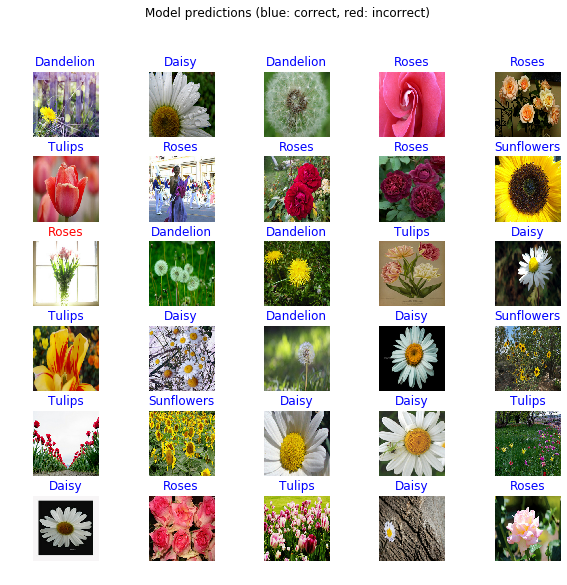

In [38]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [0]:
INCEPTION_URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
INC_IMAGE_RES = 299
feature_extractor = hub.KerasLayer(INCEPTION_URL, input_shape=(INC_IMAGE_RES, INC_IMAGE_RES, 3))

In [0]:
feature_extractor.trainable = False

In [0]:
def format_image(image, label):
    image = tf.image.resize(image, (INC_IMAGE_RES, INC_IMAGE_RES)) / 255.
    return image, label

train_batches = training_set.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [21]:
L = [
    feature_extractor,
    tf.keras.layers.Dense(units=num_classes, activation='softmax')
]
model = tf.keras.Sequential(L)

In [22]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [23]:
EPOCHS = 6
history = model.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)

Epoch 1/6
93/93 [==============================] - 43s 463ms/step - loss: 0.7320 - acc: 0.7434 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/6
93/93 [==============================] - 35s 378ms/step - loss: 0.3820 - acc: 0.8820 - val_loss: 0.4015 - val_acc: 0.8653
Epoch 3/6
93/93 [==============================] - 35s 376ms/step - loss: 0.3037 - acc: 0.9078 - val_loss: 0.3658 - val_acc: 0.8764
Epoch 4/6
93/93 [==============================] - 35s 375ms/step - loss: 0.2574 - acc: 0.9197 - val_loss: 0.3450 - val_acc: 0.8806
Epoch 5/6
93/93 [==============================] - 35s 375ms/step - loss: 0.2247 - acc: 0.9292 - val_loss: 0.3311 - val_acc: 0.8875
Epoch 6/6
93/93 [==============================] - 35s 375ms/step - loss: 0.1995 - acc: 0.9431 - val_loss: 0.3208 - val_acc: 0.8958


Text(0.5, 1.0, 'Training and Validation Loss')

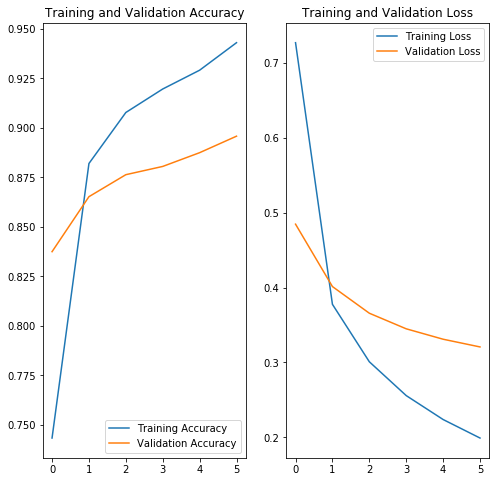

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [26]:
image_batch, label_batch = next(iter(train_batches.take(1)))
predicted_batch = model.predict(image_batch)

predicted_ids = np.argmax(predicted_batch, axis=1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

['dandelion' 'daisy' 'dandelion' 'roses' 'roses' 'tulips' 'roses' 'roses'
 'roses' 'sunflowers' 'roses' 'dandelion' 'dandelion' 'tulips' 'daisy'
 'tulips' 'daisy' 'dandelion' 'daisy' 'sunflowers' 'tulips' 'sunflowers'
 'daisy' 'daisy' 'tulips' 'daisy' 'roses' 'tulips' 'daisy' 'roses'
 'dandelion' 'tulips']


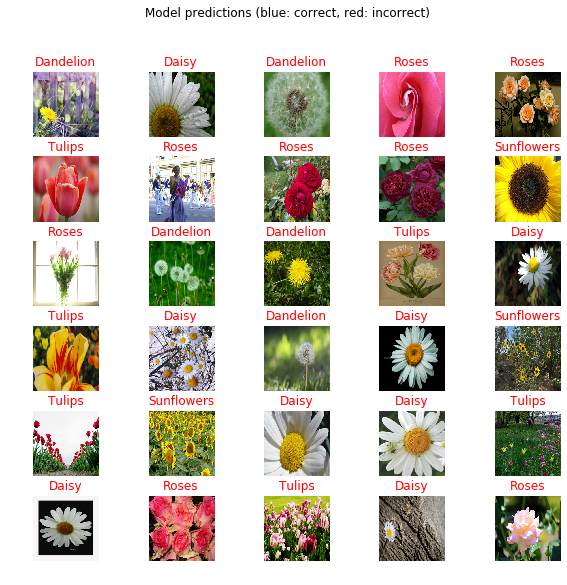

In [27]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")